# Task 2: Flowers classification
Dmytro Geleshko

## Imports

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

## TF Config

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data
### Defining classes

In [5]:
classes = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

### Loading data

We can use tensorflow's fucntion to create image dataset from a directory, but for the sake of simplicity and ease of use with opencv, we will load it manually.

In [6]:
# array of labeled data: [x, y]
data = []

for i, c_name in enumerate(classes):
    count = 0
    path = "data/" + c_name
    for root, dir, files in os.walk(path):
        for file_name in files:
            if file_name.endswith(".jpg"):
                data.append([cv2.imread(path + "/" + file_name), i])
                count += 1
    print("Loaded", count, "images of", classes[i])

Loaded 518 images of daisy
Loaded 239 images of dandelion
Loaded 472 images of roses
Loaded 420 images of sunflowers
Loaded 602 images of tulips


### Preview examples of data

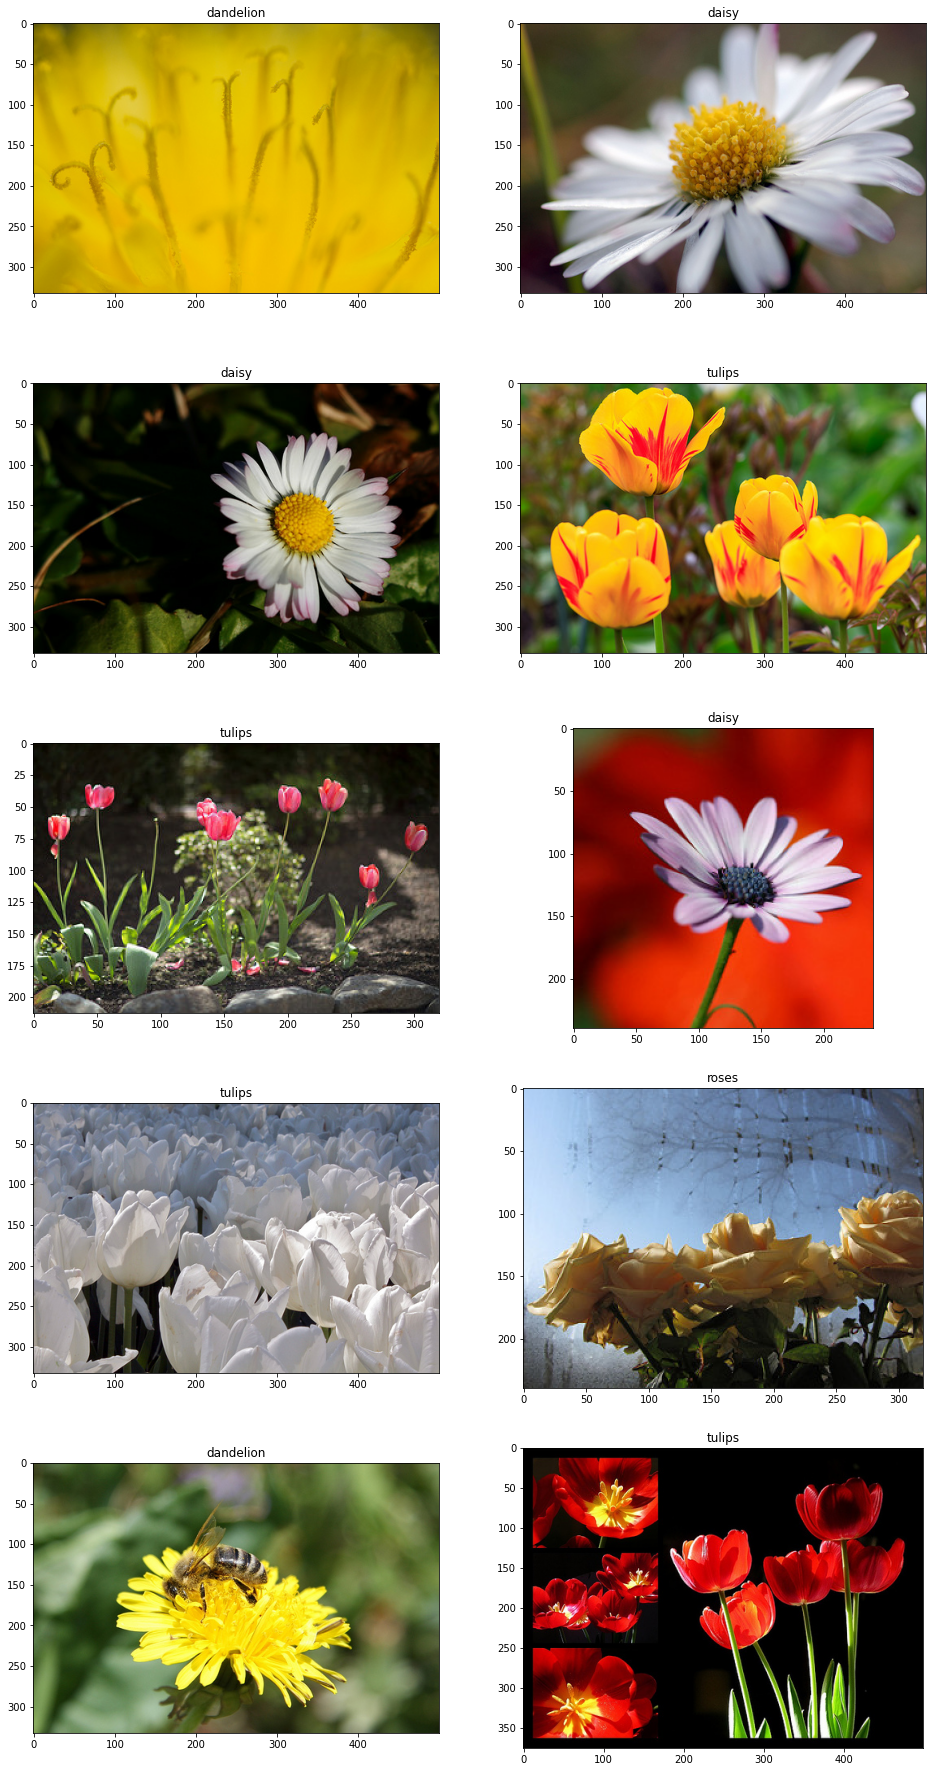

In [7]:
plt.rcParams["figure.figsize"] = (16, 32)

for i in range(10):
    rand_img = np.random.randint(0, len(data))
    plt.subplot(5, 2, i + 1)
    plt.imshow(data[rand_img][0][:,:,::-1])
    plt.title(classes[data[rand_img][1]])
plt.show()

### Image shapes

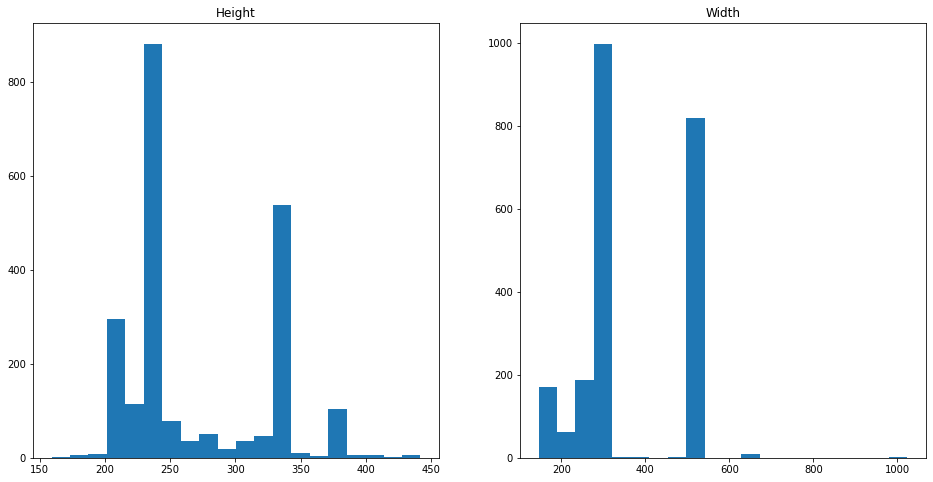

In [8]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.hist([x.shape[0] for x, _ in data], 20)
plt.title("Height")
plt.subplot(1, 2, 2)
plt.hist([x.shape[1] for x, _ in data], 20)
plt.title("Width")
plt.show()

For out first FC Neural Network the difference in shapes doesn't really matter because we will extract features into a flat array of fixed size. But for the Convolutional Neural Network we will have to deal with that (crop or scale).

### Data Split

In [9]:
random.shuffle(data)

train = data[:int(len(data) * 0.7)]
dev = data[int(len(data) * 0.7): int(len(data) * 0.85)]
test = data[int(len(data) * 0.85):]

print("Train:", len(train))
print("Dev:", len(dev))
print("Test:", len(test))

Train: 1575
Dev: 338
Test: 338


## FC Neural Network
### Preprocessing

In [9]:
def get_img_features(img, bins=64):
    # get hist of each channel
    b_hist, _ = np.histogram(img[:, :, 0], bins=bins)
    g_hist, _ = np.histogram(img[:, :, 1], bins=bins)
    r_hist, _ = np.histogram(img[:, :, 2], bins=bins)
    # concatanate, and return scaled
    hist = np.concatenate((b_hist, g_hist, r_hist), axis=0)
    return (hist / hist.max()).astype(np.float32)

def nn_prepare_data(data, n_classes):
    x = np.array([get_img_features(x) for x, y in data], dtype=np.float32)
    y = keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
    return x, y

In [10]:
nn_train_x, nn_train_y = nn_prepare_data(train, len(classes))
print("X:", nn_train_x.shape, nn_train_x.dtype)
print("Y:", nn_train_y.shape, nn_train_y.dtype)

X: (1575, 192) float32
Y: (1575, 5) float32


In [11]:
nn_dev_x, nn_dev_y = nn_prepare_data(dev, len(classes))
print("X:", nn_dev_x.shape, nn_dev_x.dtype)
print("Y:", nn_dev_y.shape, nn_dev_y.dtype)

X: (338, 192) float32
Y: (338, 5) float32


### Architecture

In [12]:
def build_nn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Dense(32)(X_in)
    X = layers.ReLU()(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [13]:
nn = build_nn((192), len(classes))
print(nn.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192)]             0         
                                                                 
 dense (Dense)               (None, 32)                6176      
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 re_lu_1 (ReLU)              (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
 softmax (Softmax)           (None, 5)                 0     

In [14]:
nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [15]:
nn_hist_train = nn.fit(x=nn_train_x, y=nn_train_y, validation_data=(nn_dev_x, nn_dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 1s 5ms/step - loss: 1.5579 - categorical_accuracy: 0.2756 - val_loss: 1.5322 - val_categorical_accuracy: 0.2811
Epoch 2/25
50/50 [==============================] - 0s 2ms/step - loss: 1.4503 - categorical_accuracy: 0.3810 - val_loss: 1.4326 - val_categorical_accuracy: 0.3402
Epoch 3/25
50/50 [==============================] - 0s 2ms/step - loss: 1.3671 - categorical_accuracy: 0.4260 - val_loss: 1.3663 - val_categorical_accuracy: 0.3905
Epoch 4/25
50/50 [==============================] - 0s 3ms/step - loss: 1.3114 - categorical_accuracy: 0.4673 - val_loss: 1.3362 - val_categorical_accuracy: 0.4260
Epoch 5/25
50/50 [==============================] - 0s 2ms/step - loss: 1.2814 - categorical_accuracy: 0.4737 - val_loss: 1.3121 - val_categorical_accuracy: 0.4467
Epoch 6/25
50/50 [==============================] - 0s 3ms/step - loss: 1.2522 - categorical_accuracy: 0.4832 - val_loss: 1.2940 - val_categorical_accuracy: 0.4467
Epoch 7/25
50/50

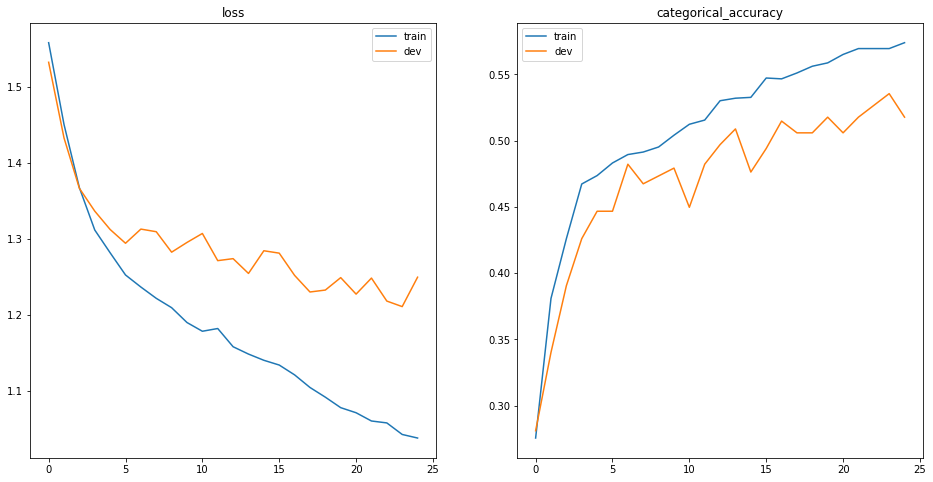

In [16]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(nn_hist_train.history["loss"], label="train")
plt.plot(nn_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(nn_hist_train.history["categorical_accuracy"], label="train")
plt.plot(nn_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

## Convolutional Neural Network
### Preprocessing

In [17]:
def cnn_prepare_data(data, h, w, n_classes):
    x = np.array([
        tf.image.resize_with_crop_or_pad((x / 255).astype(np.float32),
        target_height=h, target_width=w) for x, y in data], dtype=np.float32)

    y = keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
    return x, y

In [18]:
cnn_train_x, cnn_train_y = cnn_prepare_data(train, 192, 192, len(classes))
print("X:", cnn_train_x.shape, cnn_train_x.dtype)
print("Y:", cnn_train_y.shape, cnn_train_y.dtype)

X: (1575, 192, 192, 3) float32
Y: (1575, 5) float32


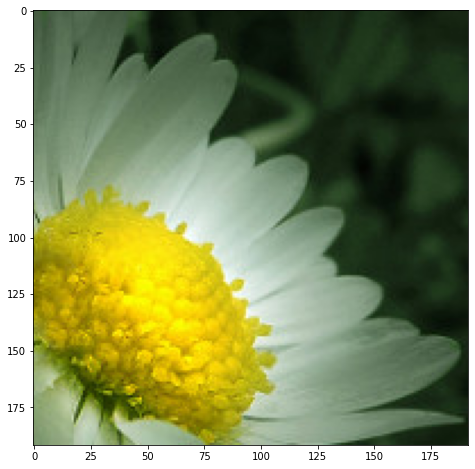

[1. 0. 0. 0. 0.]


In [19]:
example = 5
plt.imshow(cnn_train_x[example, :, :, ::-1])
plt.show()
print(cnn_train_y[example])

In [20]:
cnn_dev_x, cnn_dev_y = cnn_prepare_data(dev, 192, 192, len(classes))
print("X:", cnn_dev_x.shape, cnn_dev_x.dtype)
print("Y:", cnn_dev_y.shape, cnn_dev_y.dtype)

X: (338, 192, 192, 3) float32
Y: (338, 5) float32


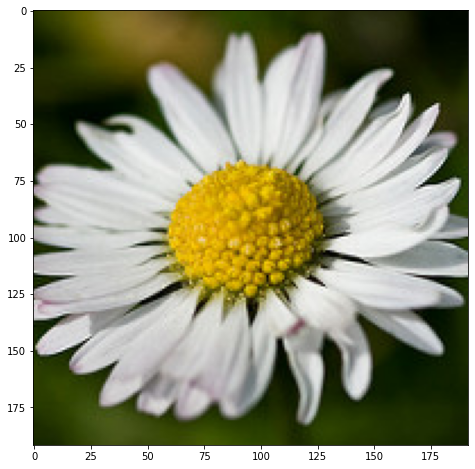

[1. 0. 0. 0. 0.]


In [21]:
example = 5
plt.imshow(cnn_dev_x[example, :, :, ::-1])
plt.show()
print(cnn_dev_y[example])

### Architecture

In [36]:
def build_cnn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Conv2D(4, (3, 3), padding="valid")(X_in)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(8, (3, 3), padding="valid")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(8, (3, 3), padding="valid")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(16, (3, 3), padding="valid")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(16, (3, 3), padding="valid")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Flatten()(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

Here i'm doing Conv2D with 4, 8, 8, 16, 16 filters, then FC.

I also tried 4, 8, 16, 32... config with "same" and "valid" paddings but those were too complex for this task.

In [40]:
cnn = build_cnn((192, 192, 3), len(classes))
print(cnn.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 190, 190, 4)       112       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 95, 95, 4)        0         
 g2D)                                                            
                                                                 
 re_lu_29 (ReLU)             (None, 95, 95, 4)         0         
                                                                 
 batch_normalization_23 (Bat  (None, 95, 95, 4)        16        
 chNormalization)                                                
                                                                 
 conv2d_38 (Conv2D)          (None, 93, 93, 8)         296 

In [41]:
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [42]:
cnn_hist_train = cnn.fit(x=cnn_train_x, y=cnn_train_y, validation_data=(cnn_dev_x, cnn_dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 16s 308ms/step - loss: 1.5385 - categorical_accuracy: 0.3340 - val_loss: 1.5822 - val_categorical_accuracy: 0.2456
Epoch 2/25
50/50 [==============================] - 15s 294ms/step - loss: 1.1737 - categorical_accuracy: 0.5060 - val_loss: 1.6855 - val_categorical_accuracy: 0.2544
Epoch 3/25
50/50 [==============================] - 13s 268ms/step - loss: 1.0817 - categorical_accuracy: 0.5575 - val_loss: 1.7160 - val_categorical_accuracy: 0.2160
Epoch 4/25
50/50 [==============================] - 11s 226ms/step - loss: 1.0150 - categorical_accuracy: 0.5727 - val_loss: 1.9547 - val_categorical_accuracy: 0.2160
Epoch 5/25
50/50 [==============================] - 9s 183ms/step - loss: 0.9563 - categorical_accuracy: 0.6038 - val_loss: 2.0125 - val_categorical_accuracy: 0.2160
Epoch 6/25
50/50 [==============================] - 10s 191ms/step - loss: 0.9022 - categorical_accuracy: 0.6444 - val_loss: 2.1282 - val_categorical_accuracy: 0.2219

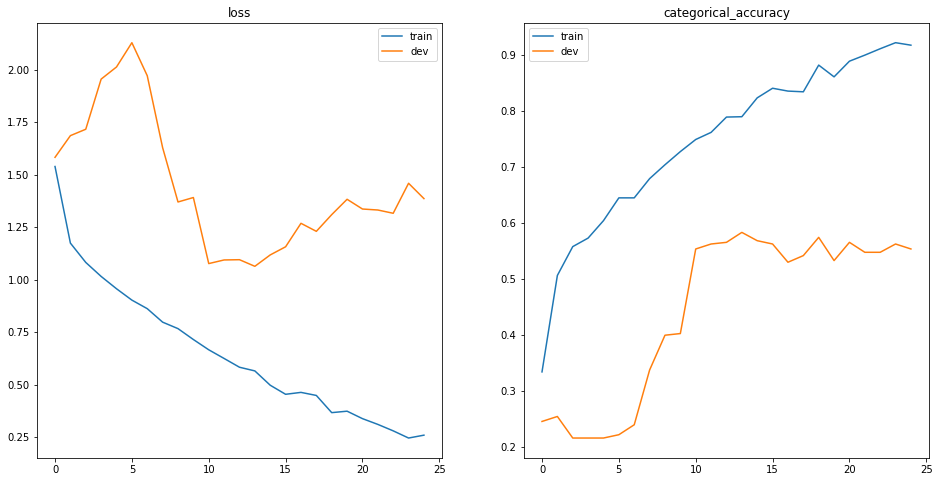

In [43]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn_hist_train.history["loss"], label="train")
plt.plot(cnn_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

### Architecture #2: Inception  and skip connections

In [38]:
def inception_block(input, f1, k1, f2, k2, f3, k3):
    # apply different filters
    X1 = layers.Conv2D(f1, k1, padding="same")(input)
    X2 = layers.Conv2D(f2, k2, padding="same")(input)
    X3 = layers.Conv2D(f3, k3, padding="same")(input)
    # concatanate them, MaxPool, ReLU, BatchNorm
    X = layers.concatenate([X1, X2, X3])
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    # skip-connection, with MaxPool'ed input so that the dimentions are matched with the rest
    P = layers.MaxPool2D()(input)
    X = layers.concatenate([X, P])
    return X


def build_inception_cnn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = inception_block(
        X_in,
        1, (1, 1),
        1, (3, 3),
        1, (5, 5))
    X = inception_block(
        X,
        1, (1, 1),
        1, (3, 3),
        1, (5, 5))
    X = inception_block(
        X,
        1, (1, 1),
        1, (3, 3),
        1, (5, 5))
    X = inception_block(
        X,
        1, (1, 1),
        1, (3, 3),
        1, (5, 5))
    X = inception_block(
        X,
        1, (1, 1),
        1, (3, 3),
        1, (5, 5))
    X = inception_block(
        X,
        1, (1, 1),
        1, (3, 3),
        1, (5, 5))
    # REMOVE
    X = inception_block(
        X,
        1, (1, 1),
        1, (3, 3),
        1, (5, 5))
    
    X = layers.Flatten()(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [28]:
cnn2 = build_inception_cnn((192, 192, 3), len(classes))
print(cnn2.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 192, 192, 1)  4           ['input_3[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 192, 192, 1)  28          ['input_3[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 192, 192, 1)  76          ['input_3[0][0]']          

In [29]:
cnn2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [30]:
cnn2_hist_train = cnn2.fit(x=cnn_train_x, y=cnn_train_y, validation_data=(cnn_dev_x, cnn_dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 32s 605ms/step - loss: 1.6563 - categorical_accuracy: 0.3822 - val_loss: 1.6677 - val_categorical_accuracy: 0.3166
Epoch 2/25
50/50 [==============================] - 28s 553ms/step - loss: 1.1917 - categorical_accuracy: 0.5194 - val_loss: 1.5125 - val_categorical_accuracy: 0.3580
Epoch 3/25
50/50 [==============================] - 27s 544ms/step - loss: 1.0848 - categorical_accuracy: 0.5676 - val_loss: 1.2987 - val_categorical_accuracy: 0.4793
Epoch 4/25
50/50 [==============================] - 27s 544ms/step - loss: 1.0156 - categorical_accuracy: 0.5867 - val_loss: 1.2000 - val_categorical_accuracy: 0.5118
Epoch 5/25
50/50 [==============================] - 27s 531ms/step - loss: 0.9536 - categorical_accuracy: 0.6133 - val_loss: 1.1003 - val_categorical_accuracy: 0.5621
Epoch 6/25
50/50 [==============================] - 26s 522ms/step - loss: 0.8950 - categorical_accuracy: 0.6337 - val_loss: 1.0117 - val_categorical_accuracy: 0.562

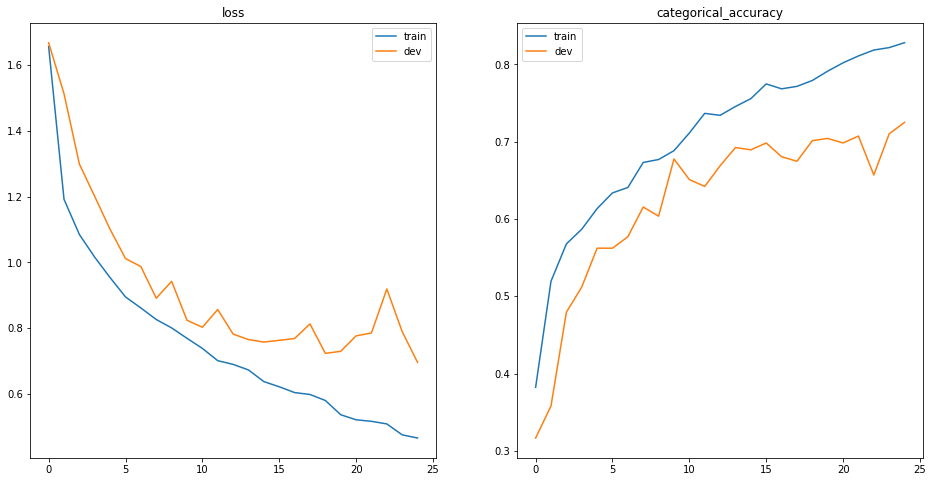

In [32]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn2_hist_train.history["loss"], label="train")
plt.plot(cnn2_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn2_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn2_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

Much better but overfitting is still significant

## Data Augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.3),
  layers.RandomContrast(0.1)
])

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_data_adv(data, h, w, n_classes, batch_size=32, shuffle=False, augment=False):
  
  ds = tf.data.Dataset.from_tensor_slices((
    np.array([
        tf.image.resize_with_crop_or_pad((x / 255).astype(np.float32),
        target_height=h, target_width=w) for x, y in data], dtype=np.float32),

        keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
  ))

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
train_ds = prepare_data_adv(train, 192, 192, len(classes), shuffle=True, augment=True)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [15]:
dev_ds = prepare_data_adv(dev, 192, 192, len(classes))
dev_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

### CNN on Augmented Data

In [39]:
cnn3 = build_inception_cnn((192, 192, 3), len(classes))
print(cnn3.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 192, 192, 1)  4           ['input_9[0][0]']                
                                                                                                  
 conv2d_153 (Conv2D)            (None, 192, 192, 1)  28          ['input_9[0][0]']                
                                                                                                  
 conv2d_154 (Conv2D)            (None, 192, 192, 1)  76          ['input_9[0][0]']          

In [40]:
cnn3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [41]:
cnn3_hist_train = cnn3.fit(train_ds, validation_data=dev_ds, epochs=25)

Epoch 1/25
50/50 [==============================] - 8s 129ms/step - loss: 1.7456 - categorical_accuracy: 0.3689 - val_loss: 1.5089 - val_categorical_accuracy: 0.3373
Epoch 2/25
50/50 [==============================] - 8s 133ms/step - loss: 1.1182 - categorical_accuracy: 0.5644 - val_loss: 1.4614 - val_categorical_accuracy: 0.3550
Epoch 3/25
50/50 [==============================] - 8s 143ms/step - loss: 1.0232 - categorical_accuracy: 0.6127 - val_loss: 1.4618 - val_categorical_accuracy: 0.3757
Epoch 4/25
50/50 [==============================] - 7s 128ms/step - loss: 0.9734 - categorical_accuracy: 0.6292 - val_loss: 1.3217 - val_categorical_accuracy: 0.4586
Epoch 5/25
50/50 [==============================] - 7s 124ms/step - loss: 0.9417 - categorical_accuracy: 0.6229 - val_loss: 1.0736 - val_categorical_accuracy: 0.5385
Epoch 6/25
50/50 [==============================] - 7s 117ms/step - loss: 0.9238 - categorical_accuracy: 0.6406 - val_loss: 1.0209 - val_categorical_accuracy: 0.5947
Epoc

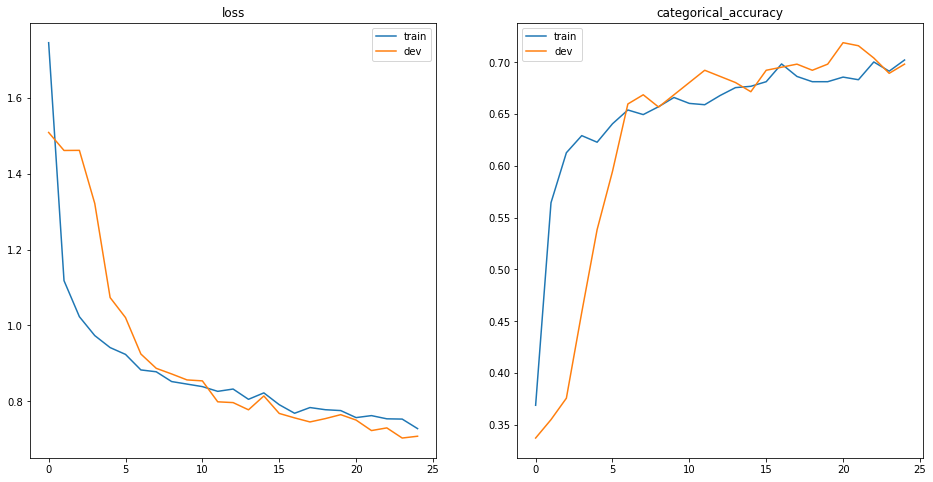

In [42]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn3_hist_train.history["loss"], label="train")
plt.plot(cnn3_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn3_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn3_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

### Architecture #3: More complex

In [44]:
def build_inception_cnn_adv(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = inception_block(
        X_in,
        2, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        2, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        2, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        2, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        2, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        2, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    
    X = layers.Flatten()(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [45]:
cnn4 = build_inception_cnn_adv((192, 192, 3), len(classes))
print(cnn4.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_173 (Conv2D)            (None, 192, 192, 2)  8           ['input_10[0][0]']               
                                                                                                  
 conv2d_174 (Conv2D)            (None, 192, 192, 2)  56          ['input_10[0][0]']               
                                                                                                  
 conv2d_175 (Conv2D)            (None, 192, 192, 2)  152         ['input_10[0][0]']         

In [46]:
cnn4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [47]:
cnn4_hist_train = cnn4.fit(train_ds, validation_data=dev_ds, epochs=25)

Epoch 1/25
50/50 [==============================] - 10s 146ms/step - loss: 1.4935 - categorical_accuracy: 0.3797 - val_loss: 1.5310 - val_categorical_accuracy: 0.3107
Epoch 2/25
50/50 [==============================] - 8s 136ms/step - loss: 1.1318 - categorical_accuracy: 0.5232 - val_loss: 1.6674 - val_categorical_accuracy: 0.3136
Epoch 3/25
50/50 [==============================] - 8s 145ms/step - loss: 0.9609 - categorical_accuracy: 0.5860 - val_loss: 1.5656 - val_categorical_accuracy: 0.3580
Epoch 4/25
50/50 [==============================] - 7s 131ms/step - loss: 0.8600 - categorical_accuracy: 0.6337 - val_loss: 1.3935 - val_categorical_accuracy: 0.4527
Epoch 5/25
50/50 [==============================] - 8s 142ms/step - loss: 0.8037 - categorical_accuracy: 0.6800 - val_loss: 1.2943 - val_categorical_accuracy: 0.4911
Epoch 6/25
50/50 [==============================] - 8s 147ms/step - loss: 0.7713 - categorical_accuracy: 0.6851 - val_loss: 1.1740 - val_categorical_accuracy: 0.5444
Epo

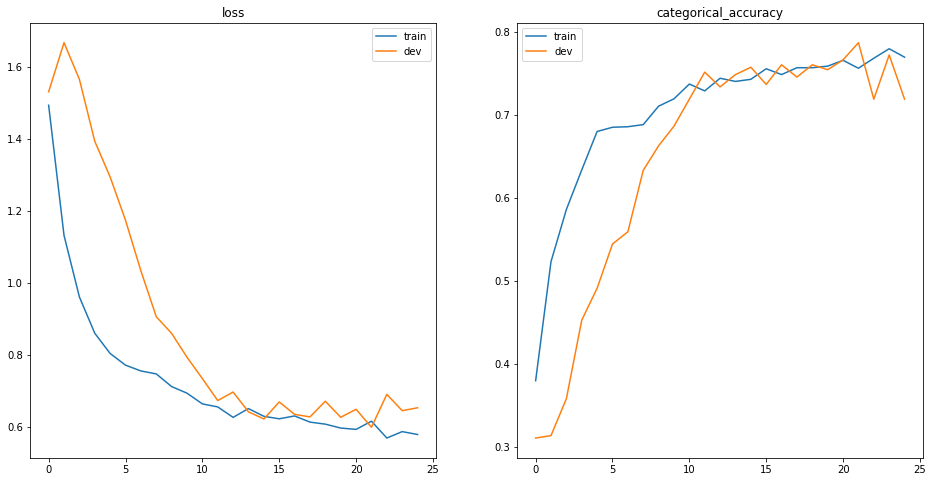

In [48]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn4_hist_train.history["loss"], label="train")
plt.plot(cnn4_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn4_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn4_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()